# Learning progress: Evaluación del BERT a lo largo de las etapas del finetuning

Lo vamos a hacer primero con un conjunto de prueba:
* Abstracts de los que se tomó la muestra: [abstracts.csv](../../pubmed-queries/abstracts/abstracts.csv)
* Muestra fenotipos/etiquetas: [index-phenotypes.csv](../../pubmed-queries/abstracts/index-phenotypes.csv)
* Fenotipos test: [phenotypes-22-12-15.csv](../pubmed-queries/results/phenotypes-22-12-15.csv) = nodos hoja HPO:PhenotypicAbnormality

Pasos a seguir:
1. Cargar todos los datos:
  * BERT de partida.
  * Ontología.
  * Datos crudos de entrenamiento (abstracts+fenotipos).
2. Preparar el entrenamiento:
  * Datos procesados de train (dataloaders)
  * Función de pérdida: BatchAllTripletLoss
  * Función de evaluación:
    * a) EmbeddingSimilarityEvaluator
      * Preparar pares de fenotipos (train/test?)
      * Calcular gold scores
    * b) Implementarla (SentenceEvaluator) con la funcionalidad:
      * Calcular MSE y correlación Train/Test.
      * Escribir datos en un csv.
      * Devolver la correlación de Test.
3. Fit: probar en el servidor y guardar los resultados.
4. Out: mostrar e interpretar los resultados.
  * Gráfica MSE / etapa (train/test)
  * Gráfica correlación / etapa (train/test)

## 1. Cargar todos los datos

In [91]:
# IMPORTS
from cmath import nan
import sentence_transformers
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [92]:
# 1. Cargar todos los datos (crudos)
from pyhpo import Ontology
import os

SRCPATH = '../..'
SEED = 42

# 1.1 BERT de partida

PRITAMDEKAMODEL = 'pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb'
bertmodel = SentenceTransformer(PRITAMDEKAMODEL)
model = bertmodel

# 1.2 Ontología

onto = Ontology(SRCPATH+ '/pubmed-queries/hpo-22-12-15-data')

# 1.3 Datos crudos de entrenamiento

PATH_DATA = SRCPATH + '/pubmed-queries/abstracts'
PATH_DATA_CSV = PATH_DATA + '/abstracts.csv'
PATH_DATA_FENOTIPOS = SRCPATH + '/pubmed-queries/results/phenotypes-22-12-15.csv'
PATH_INDEX_FENOTIPOS = PATH_DATA + '/index-phenotypes.csv'

# abstracts
dfPapers = pd.read_csv(PATH_DATA_CSV, sep='\t', low_memory=False, na_values=['', nan])
# fenotipos test
dfPhenotypes = pd.read_csv(PATH_DATA_FENOTIPOS, sep=';', low_memory=False, na_values=['', nan])
# fenotipos train
dfIndex = pd.read_csv(PATH_INDEX_FENOTIPOS, sep='\t', low_memory=False, na_values=['', nan])

# Guardar en directorio manejable
PATH_TRAINDATA = SRCPATH + '/traindata'

# crear directorios si no existen
for dir in [PATH_TRAINDATA, PATH_TRAINDATA + '/abstracts',
            PATH_TRAINDATA + '/phenotypes', PATH_TRAINDATA + '/onto']:
    if not os.path.exists(dir):
        os.makedirs(dir)

dfPapers.to_csv(PATH_TRAINDATA + '/abstracts/abstracts.csv', sep='\t', index=False)
dfPhenotypes.to_csv(PATH_TRAINDATA + '/phenotypes/phenotypes.csv', sep=';', index=False)
dfIndex.to_csv(PATH_TRAINDATA + '/phenotypes/index.csv', sep='\t', index=False)

# copiar ontology al directorio tambien
os.system('cp -r ' + SRCPATH + '/pubmed-queries/hpo-22-12-15-data ' + PATH_TRAINDATA + '/onto')


0

## 2. Preparar el entrenamiento

In [93]:
# Procesar los datos de train/loss/test

# 2.1. Clean abstracts

# Tratar NA's en la columna abstracts -> cambiar por el título
def getPhenDesc(phenotypeName):
    hpoNode = onto.get_hpo_object(phenotypeName) 
    description = hpoNode.definition if hpoNode.definition else '""'
    return description

print('Na\'s:', dfPapers['abstract'].isna().sum())
dfPapers['abstract'] = dfPapers['abstract'].fillna(dfPapers['title'])

# Función clean abstract

# Download the stopwords from NLTK
PATH_NTLK = SRCPATH + '/traindata/nltk'
if not os.path.exists(PATH_NTLK):
    os.makedirs(PATH_NTLK)

os.environ['NLTK_DATA'] = PATH_NTLK

nltk.download('punkt')
nltk.download('stopwords')

cached_stopwords = stopwords.words('english')
def clean_abstract(abstract):
    if isinstance(abstract, float) and np.isnan(abstract):
        return ''
    # Convert the text to lowercase
    abstract = abstract.lower()

    # Remove punctuation
    abstract = abstract.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(abstract)

    # Remove stopwords
    tokens = [word for word in tokens if not word in cached_stopwords]

    # Join the tokens back into a single string
    abstract = ' '.join(tokens)

    return abstract

# Save clean abstracts csv

dfPapers['clean_abstract'] = dfPapers['abstract'].apply(clean_abstract)
dfPapers.drop(columns=['abstract'], inplace=True)
dfPapers.to_csv(PATH_TRAINDATA + '/abstracts/abstracts-clean.csv', sep='\t', index=False)

print('Clean abstracts in: ', PATH_TRAINDATA + '/abstracts/abstracts-clean.csv')
print('Total abstracts: ', len(dfPapers))

# 2.2 Tags = phenotypes (train)

tags = dfIndex['phenotypeName']
numlabels = len(tags)
print('Number of phenotype tags:', numlabels)
mapping = {tag: i for i, tag in enumerate(tags)}

def getLabelNumber(phenotypeName):
    return mapping[phenotypeName]

Na's: 1854


[nltk_data] Downloading package punkt to /home/domingo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/domingo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Clean abstracts in:  ../../traindata/abstracts/abstracts-clean.csv
Total abstracts:  23226
Number of phenotype tags: 100


### 2.3 Profiling
Tomamos solo una muestra del 5% de los abstracts totales para realizar las pruebas más rápido. Cuando funcionen las pruebas se cambia para la versión oficial del experimento.

In [94]:
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, evaluation, InputExample

PROFILING = True
SAMPLEPERCENT = 0.005 if PROFILING else 1.0
SEED = 42
torch.manual_seed(SEED)

dTrain = dfPapers.sample(frac=SAMPLEPERCENT, random_state=SEED)
numexamples = len(dTrain)
print('Number of train examples:', numexamples)
dTrain.to_csv(PATH_TRAINDATA + '/abstracts/abstracts-train.csv', sep='\t', index=False)

Number of train examples: 116


### 2.4 Dataloaders

In [95]:
# Ejemplos de entrenamiento

# pares (abstract,fenotipo)
abstractsTrain = [InputExample(texts=[clean_abstract(x)], label=mapping[y]) for x, y in zip(dTrain['clean_abstract'], dTrain['phenotypeName'])]
train_dataloader = DataLoader(abstractsTrain, shuffle=True, batch_size=16)

from itertools import combinations
import itertools
import random

# Ejemplos de evaluación (train)

def onto_sim(name1, name2):
    phen1 = onto.get_hpo_object(name1)
    phen2 = onto.get_hpo_object(name2)
    sim = min(phen1.similarity_score(phen2, method='lin'),1)
    return sim

# Son pares de fenotipos (con su gold score si es necesario)
dmp = pd.DataFrame(dfIndex, columns=['phenotypeName'])
index_pairs = combinations(range(0,len(dmp)), 2)

lpairs = list(combinations(dmp['phenotypeName'], 2))
ltrain1, ltrain2 = zip(*lpairs) # 2 listas diferentes para pasar como parámetro al evaluator

goldTrain = [onto_sim(pair[0], pair[1]) for pair in lpairs]

# Ejemplos de evaluación (test)

import random

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

# Obtén una lista de todos los valores únicos en la columna 'phenotypeName'

num_samples = 100  # Number of combinations to sample
print('Number of test pairs samples:', num_samples)

# Usa random_combination para obtener una muestra aleatoria de 2000 pares
sample_pairs = [random_combination(dfPhenotypes['Phenotype'], 2) for _ in range(num_samples)]
ltest1, ltest2 = zip(*sample_pairs)

goldTest = [onto_sim(pair[0], pair[1]) for pair in sample_pairs]

# Guardar los pares de evaluación

dfVal = pd.DataFrame({'phenotype1': ltrain1, 'phenotype2': ltrain2, 'lin': goldTrain})
dfTest = pd.DataFrame({'phenotype1': ltest1, 'phenotype2': ltest2, 'lin': goldTest})

if not os.path.exists(PATH_TRAINDATA + '/evaluation'):
    os.makedirs(PATH_TRAINDATA + '/evaluation')

dfVal.to_csv(PATH_TRAINDATA + '/evaluation/pairs-val.csv', sep='\t', index=False)
dfTest.to_csv(PATH_TRAINDATA + '/evaluation/pairs-test.csv', sep='\t', index=False)

Number of test pairs samples: 100


### 2.6 Funciones de pérdida y evaluación
* Primero probaremos la opción a) con la función predefinida EmbeddingSimilarityEvaluator para los datos de train.

In [96]:
# Loss function
from sentence_transformers.evaluation import SimilarityFunction

MARGIN = 0.3743
print(f'Loss Function: BatchAllTripletLoss(margin={MARGIN})')
train_loss = losses.BatchAllTripletLoss(model=model, distance_metric=losses.BatchHardTripletLossDistanceFunction.cosine_distance, margin=MARGIN)

# Evaluator

# a)

evaluatorTrain=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltrain1, ltrain2, goldTrain,
                                                                             main_similarity=SimilarityFunction.COSINE,
                                                                             name='train')
evaluatorTest=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltest1, ltest2, goldTest,
                                                                            main_similarity=SimilarityFunction.COSINE,
                                                                            name='test')
combined_evaluator = evaluation.SequentialEvaluator([evaluatorTrain, evaluatorTest],
                                                    main_score_function=lambda scores: scores[1])
# test score prevalece

print('Evaluator: EmbeddingSimilarityEvaluator(cosine_similarity)')

Loss Function: BatchAllTripletLoss(margin=0.3743)
Evaluator: EmbeddingSimilarityEvaluator(cosine_similarity)


### 3. Fit

In [97]:
num_epochs = 2
num_examples = len(dTrain)
ev_steps = len(train_dataloader)//5 # 5 evaluations per epoch

if not os.path.exists(SRCPATH + '/output'):
    os.makedirs(SRCPATH + '/output')

print(f'Fit parameters: num_epochs={num_epochs},',
      f'evaluation_steps={ev_steps},warmup_steps={int(0.25*(num_examples//16))}')

Fit parameters: num_epochs=2, evaluation_steps=1,warmup_steps=1


In [98]:
print("Fitting...")
import time

start_time = time.time()

fmodel = model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=combined_evaluator,
    epochs=num_epochs,
    #evaluation_steps=(num_examples//16)//num_epochs//2,
    evaluation_steps=ev_steps,
    warmup_steps=int(0.25*(num_examples//16)),
    output_path=SRCPATH+'/output/fine-tuned-bio-bert-ev',
    save_best_model=True,
    checkpoint_path='./checkpoint',
    checkpoint_save_steps=ev_steps,
    checkpoint_save_total_limit=num_epochs
)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time for model.fit: {execution_time:.2f} seconds")

Fitting...


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Execution time for model.fit: 2809.38 seconds


 ## Resultados
El modelo obtenido queda en el directorio [src/output/fine-tuned-bio-bert-ev](../../output/fine-tuned-bio-bert-ev/README.md) y en él hay un subdirectorio eval donde están los csv resultantes de los pasos de evaluación. Los pasos a seguir para analizar los resultados son:
1. Calcular score original del modelo model (train y test)
2. Obtener los y=scores (pearson) y x = train_step
3. Dibujar las gráficas de correlación de train y test
4. Analizar los resultados y determinar el próximo objetivo

In [104]:
# Cargar modelo de nuevo (se sobreescribe al hacer fit)
bertmodel = SentenceTransformer(PRITAMDEKAMODEL)
model = bertmodel

# 1. Calcular score original

EVPATH = SRCPATH + '/output/fine-tuned-bio-bert-ev/eval'
scoreTrain = evaluatorTrain.__call__(model=bertmodel, output_path=EVPATH, epoch=0, steps=0)
scoreTest = evaluatorTest.__call__(model=bertmodel, output_path=EVPATH, epoch=0, steps=0)
print(f'Original score (spearman): {scoreTrain} (train), {scoreTest} (test)')

Original score (spearman): 0.056239004381953034 (train), 0.06420553740952822 (test)


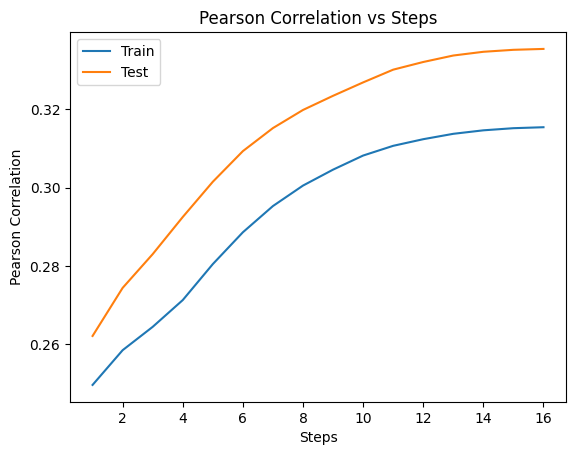

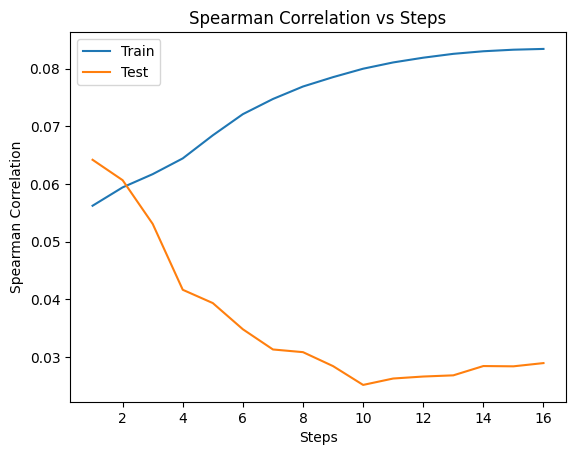

In [111]:
# 2. Obtener los y=pearson, x=steps

dfScoreTrain = pd.read_csv(EVPATH + '/similarity_evaluation_train_results.csv')
dfScoreTest = pd.read_csv(EVPATH + '/similarity_evaluation_test_results.csv')

xtrain = []
ytrain = []
xtest = []
ytest = []
ztrain = []
ztest = []

row = dfScoreTrain.where(dfScoreTrain['steps'] == 0).iterrows().__next__()
x = row[1]['steps']*ev_steps + row[1]['epoch']*len(train_dataloader)
y = row[1]['cosine_pearson']
z = row[1]['cosine_spearman']
xtrain.append(x)
ytrain.append(y)
ztrain.append(z)

row = dfScoreTest.where(dfScoreTest['steps'] == 0).iterrows().__next__()
x = row[1]['steps']*ev_steps + row[1]['epoch']*len(train_dataloader)
y = row[1]['cosine_pearson']
z = row[1]['cosine_spearman']
xtrain.append(x)
ytrain.append(y)
ztrain.append(z)

for row in dfScoreTrain.iterrows():
    if row[1]['steps'] <= 0:
        continue
    x = row[1]['steps']*ev_steps + row[1]['epoch']*len(train_dataloader)
    y = row[1]['cosine_pearson']
    z = row[1]['cosine_spearman']
    xtrain.append(x)
    ytrain.append(y)
    ztrain.append(z)

for row in dfScoreTest.iterrows():
    if row[1]['steps'] <= 0:
        continue
    x = row[1]['steps']*ev_steps + row[1]['epoch']*len(train_dataloader)
    y = row[1]['cosine_pearson']
    z = row[1]['cosine_spearman']
    xtest.append(x)
    ytest.append(y)
    ztest.append(z)

# 3. Graficar

import matplotlib.pyplot as plt

# Gráfica de correlación de Pearson
plt.plot(xtrain, ytrain, label='Train')
plt.plot(xtest, ytest, label='Test')
plt.xlabel('Steps')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation vs Steps')
plt.legend()
plt.show()

# Gráfica de correlación de Spearman
plt.plot(xtrain, ztrain, label='Train')
plt.plot(xtest, ztest, label='Test')
plt.xlabel('Steps')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation vs Steps')
plt.legend()
plt.show()
